In [19]:
import os
import glob
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier('haarcascade_mcs_mouth.xml')
nose_cascade = cv2.CascadeClassifier('haarcascade_mcs_nose.xml')

In [145]:
os.listdir('./data')[12:]

['uemura_rina',
 'fuziyoshi_karin',
 'moriya_akane',
 'harada_aoi',
 'tamura_hono',
 'oozono_rei',
 'oonuma_akiho',
 'yamasaki_ten',
 'saito_fuyuka',
 'ozeki_rika',
 'morita_hikaru',
 'matuda_rina',
 'seki_yumiko',
 'habu_miduho']

In [159]:
os.listdir('./data')[12:]

['uemura_rina',
 'fuziyoshi_karin',
 'moriya_akane',
 'harada_aoi',
 'tamura_hono',
 'oozono_rei',
 'oonuma_akiho',
 'yamasaki_ten',
 'saito_fuyuka',
 'ozeki_rika',
 'morita_hikaru',
 'matuda_rina',
 'seki_yumiko',
 'habu_miduho']

In [ ]:
for member_name in os.listdir('./data')[12:]:
    os.makedirs('./face/' + member_name, exist_ok=True)
    file_list = glob.glob('./data/' + member_name + '/*')
    for image_file in file_list:
        file_number = image_file.split('/')[-1].split('.')[0]
        
        input_img = cv2.imread(image_file)
        height, width, colors = input_img.shape
        img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        hypot = int(math.hypot(height, width))
        frame = np.zeros((hypot, hypot), np.uint8)
        frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), 
              int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img_gray

        results = []
        face_id_seed = 0
        
        
        for degree in range(-40, 41, 20):
            print('degree: %s' % degree)
            M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -degree, 1.0)
            rotated = cv2.warpAffine(frame, M, (hypot, hypot))

            faces = face_cascade.detectMultiScale(rotated, 1.11, 2)
            for (x, y, w, h) in faces:
                face_position = rotated[y:y+h, x:x+w]
                center = (int(x + w * 0.5), int(y + h * 0.5))
                origin = (int(hypot * 0.5), int(hypot * 0.5))
                r_degree = -degree
                center_org = rotate_coord(center, origin, r_degree)
                print('face:', (x,y,w,h), center_org)
        
                resized = face_position
                if w < 128:
                    print('resizing...')
                    resized = cv2.resize(face_position, (128, 128))
        
                result = {
                    'face_id': 'f%s' % face_id_seed,
                    'img_resized': resized, #顔候補bitmap(小さい場合zoom)
                    'img': face_position, #顔候補bitmap(元サイズ)
                    'deg': degree, #回転
                    'frame': (x, y, w, h), #回転状態における中心座標+size
                    'center_org': center_org, #角度0時における中心座標
                         }
                results.append(result)
                face_id_seed += 1
                
                
        eyes_id_seed = 0
        eyes_faces = []

        for result in results:
            print('#eyes:'),result['face_id']

            img = np.copy(result["img_resized"])
            fw,fh = img.shape
            eyes = eye_cascade.detectMultiScale(img, 1.02)
            left_eye = right_eye = None #左上/右上にそれぞれ目が１つずつ検出できればOK
            for (x,y,w,h) in eyes:
                print('## eye:',x,y,w,h,fw/8,fw/4,fh/8,fh/4)
                cv2.rectangle(img,(x,y),(x+w,y+h),(64,64,0),1)

                if not (fw/6 < w and w < fw/2):
                    print('eye width invalid')
                    continue
                if not (fh/6 < h and h < fh/2):
                    print('eye height invalid')
                    continue
                if not fh * 0.5 - (y + h * 0.5) > 0: #上半分に存在する
                    print('eye position invalid')
                    continue
                if fw * 0.5 - (x + w * 0.5) > 0:
                    if left_eye:
                        print('too many left eye')
                        continue
                    else:
                        left_eye = (x,y,w,h)
                else:
                    if right_eye:
                        print('too many right eye')
                        continue
                    else:
                        right_eye = (x,y,w,h)
            if left_eye and right_eye:
                print('>>> valid eyes detect')
                result['left_eye'] = left_eye
                result['right_eye'] = right_eye
                eyes_faces.append(result)
            
        candidates = []
        for i, result in enumerate(eyes_faces):
            print('result:',result['face_id'])
            result['duplicated'] = False
            for cand in candidates:
                c_x, c_y = cand['center_org']
                _,_,cw,ch = cand['frame']
                r_x, r_y = result['center_org']
                _,_,rw,rh = result['frame']
                if abs(c_x - r_x) < ((cw+rw)*0.5*0.3) and abs(c_y - r_y) < ((ch+rh)*0.5*0.3): #近い場所にある顔候補
                    c_diff = eyes_vertical_diff(cand)
                    r_diff = eyes_vertical_diff(result)
                    print('c_diff:',cand['face_id'],c_diff)
                    print('r_diff:',result['face_id'],r_diff)
                    if c_diff < r_diff: #より左右の目の水平位置が近いほうが採用
                        result['duplicated'] = True
                    else:
                        cand['duplicated'] = True
            candidates.append(result)
        filtered = filter(lambda n: n['duplicated'] == False, candidates)
        
        for item in filtered:
            out_file = crop_color_face(item, input_img, base_dir, file_number)

degree: -40
face: (656, 889, 43, 43) (742, 754)
resizing...
degree: -20
face: (706, 528, 126, 126) (891, 558)
resizing...
degree: 0
face: (818, 491, 135, 135) (885, 558)
degree: 20
face: (852, 913, 254, 254) (1015, 1013)
face: (688, 1545, 44, 44) (943, 1601)
resizing...
degree: 40
face: (1107, 619, 26, 26) (886, 573)
resizing...
face: (480, 1431, 56, 56) (949, 1600)
resizing...
#eyes:
## eye: 7 13 28 28 16.0 32.0 16.0 32.0
## eye: 20 37 31 31 16.0 32.0 16.0 32.0
too many left eye
## eye: 67 44 34 34 16.0 32.0 16.0 32.0
## eye: 46 68 38 38 16.0 32.0 16.0 32.0
eye position invalid
## eye: 73 92 34 34 16.0 32.0 16.0 32.0
eye position invalid
>>> valid eyes detect
#eyes:
## eye: 74 23 28 28 16.0 32.0 16.0 32.0
## eye: 11 30 31 31 16.0 32.0 16.0 32.0
>>> valid eyes detect
#eyes:
## eye: 30 23 31 31 16.875 33.75 16.875 33.75
## eye: 92 37 27 27 16.875 33.75 16.875 33.75
>>> valid eyes detect
#eyes:
## eye: 145 2 24 24 31.75 63.5 31.75 63.5
eye width invalid
## eye: 70 50 76 76 31.75 63.5 31.

In [324]:
member_name = 'yamasaki_ten'

In [325]:
file_list = glob.glob('./data/' + member_name + '/*')
file_list[:3]

['./data/yamasaki_ten/000152.jpg',
 './data/yamasaki_ten/000146.jpg',
 './data/yamasaki_ten/000191.jpg']

In [326]:
os.makedirs('./face/' + member_name, exist_ok=True)
for image_file in file_list:
    file_number = image_file.split('/')[-1].split('.')[0]
    
    input_img = cv2.imread(image_file)
    height, width, colors = input_img.shape
    img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    hypot = int(math.hypot(height, width))
    frame = np.zeros((hypot, hypot), np.uint8)
    frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), 
    
    int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img_gray
    results = []
    face_id_seed = 0
    for degree in range(-40, 41, 10):
        print('degree: %s' % degree)
        M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -degree, 1.0)
        rotated = cv2.warpAffine(frame, M, (hypot, hypot))
    
        faces = face_cascade.detectMultiScale(rotated, scaleFactor = 1.11, minNeighbors = 2, minSize = (128, 128))
        for (x, y, w, h) in faces:
            face_position = rotated[y:y+h, x:x+w]
            center = (int(x + w * 0.5), int(y + h * 0.5))
            origin = (int(hypot * 0.5), int(hypot * 0.5))
            r_degree = -degree
            center_org = rotate_coord(center, origin, r_degree)
            print('face:', (x,y,w,h), center_org)
            
            resized = face_position
            if w < 128:
                print('resizing...')
                resized = cv2.resize(face_position, (128, 128))
            
            result = {
                    'face_id': 'f%s' % face_id_seed,
                    'img_resized': resized, #顔候補bitmap(小さい場合zoom)
                    'img': face_position, #顔候補bitmap(元サイズ)
                    'deg': degree, #回転
                    'frame': (x, y, w, h), #回転状態における中心座標+size
                    'center_org': center_org, #角度0時における中心座標
                    }
            results.append(result)
            face_id_seed += 1
    eyes_id_seed = 0
    eyes_faces = []
    for result in results:
        print('#eyes:'),result['face_id']
        img = np.copy(result["img_resized"])
        fw,fh = img.shape
        eyes = eye_cascade.detectMultiScale(img, 1.02)
        left_eye = right_eye = None #左上/右上にそれぞれ目が１つずつ検出できればOK
        for (x,y,w,h) in eyes:
            print('## eye:',x,y,w,h,fw/8,fw/4,fh/8,fh/4)
            cv2.rectangle(img,(x,y),(x+w,y+h),(64,64,0),1)
            if not (fw/6 < w and w < fw/2):
                print('eye width invalid')
                continue
            if not (fh/6 < h and h < fh/2):
                print('eye height invalid')
                continue
            if not fh * 0.5 - (y + h * 0.5) > 0: #上半分に存在する
                print('eye position invalid')
                continue
            if fw * 0.5 - (x + w * 0.5) > 0:
                if left_eye:
                    print('too many left eye')
                    continue
                else:
                    left_eye = (x,y,w,h)
            else:
                if right_eye:
                    print('too many right eye')
                    continue
                else:
                    right_eye = (x,y,w,h)
        if left_eye and right_eye:
            print('>>> valid eyes detect')
            result['left_eye'] = left_eye
            result['right_eye'] = right_eye
            eyes_faces.append(result)
            
    candidates = []
    for i, result in enumerate(eyes_faces):
        print('result:',result['face_id'])
        result['duplicated'] = False
        for cand in candidates:
            c_x, c_y = cand['center_org']
            _,_,cw,ch = cand['frame']
            r_x, r_y = result['center_org']
            _,_,rw,rh = result['frame']
            if abs(c_x - r_x) < ((cw+rw)*0.5*0.3) and abs(c_y - r_y) < ((ch+rh)*0.5*0.3): #近い場所にある顔候補
                c_diff = eyes_vertical_diff(cand)
                r_diff = eyes_vertical_diff(result)
                print('c_diff:',cand['face_id'],c_diff)
                print('r_diff:',result['face_id'],r_diff)
                if c_diff < r_diff: #より左右の目の水平位置が近いほうが採用
                    result['duplicated'] = True
                else:
                    cand['duplicated'] = True
        candidates.append(result)
    filtered = filter(lambda n: n['duplicated'] == False, candidates)
    
    finals = []
    for item in filtered:
        img = np.copy(item['img_resized'])
        fw,fh = img.shape
        mouthes = mouth_cascade.detectMultiScale(img, 1.02) #faceの中心下部付近にあればOK
        mouth_found = False
        for (mx,my,mw,mh) in mouthes:
            print('mouth',(mx,my,mw,mh))
            cv2.rectangle(img,(mx,my),(mx+mw,my+mh),(128,128,0),2)
            h_diff = fh/2 - (my+mh/2)
            print(fh, h_diff)
            if h_diff < 0:
                mouth_found = True
                break
        if mouth_found:
            finals.append(item)
    
    
    res = []
    for item in finals:
        out_file = crop_color_face(item, input_img, base_dir, file_number)

degree: -40
degree: -30
degree: -20
face: (361, 470, 246, 246) (561, 506)
degree: -10
face: (389, 402, 280, 280) (572, 503)
face: (894, 616, 392, 392) (1077, 867)
degree: 0
face: (439, 373, 265, 265) (571, 505)
face: (855, 634, 436, 436) (1073, 852)
degree: 10
face: (492, 344, 258, 258) (571, 503)
degree: 20
degree: 30
degree: 40
face: (713, 915, 180, 180) (946, 927)
#eyes:
## eye: 34 66 67 67 30.75 61.5 30.75 61.5
## eye: 140 42 51 51 30.75 61.5 30.75 61.5
## eye: 126 31 29 29 30.75 61.5 30.75 61.5
eye width invalid
## eye: 113 167 54 54 30.75 61.5 30.75 61.5
eye position invalid
## eye: 110 135 38 38 30.75 61.5 30.75 61.5
eye width invalid
>>> valid eyes detect
#eyes:
## eye: 156 72 51 51 35.0 70.0 35.0 70.0
## eye: 47 78 67 67 35.0 70.0 35.0 70.0
## eye: 127 53 41 41 35.0 70.0 35.0 70.0
eye width invalid
## eye: 118 159 38 38 35.0 70.0 35.0 70.0
eye width invalid
## eye: 101 187 65 65 35.0 70.0 35.0 70.0
eye position invalid
>>> valid eyes detect
#eyes:
## eye: 251 39 21 21 49.0 98.

In [25]:
def rotate_coord(pos, origin, deg):
    """
    posをdeg度回転させた座標を返す
    pos: 対象となる座標tuple(x,y)
    origin: 原点座標tuple(x,y)
    deg: 回転角度
    @return: 回転後の座標tuple(x,y)
    """
    x, y = pos
    ox, oy = origin
    r = np.radians(deg)
    xd = ((x - ox) * np.cos(r) - (y - oy) * np.sin(r)) + ox
    xy = ((x - ox) * np.sin(r) + (y - oy) * np.cos(r)) + oy
    return (int(xd), int(xy))

In [5]:
def crop_color_face(item, img, base_dir, file_number):
    height, width, colors = img.shape
    hypot = int(math.hypot(height, width))
    frame = np.zeros((hypot, hypot, 3), np.uint8)
    frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img

    deg = item['deg']
    M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -deg, 1.0)
    rotated = cv2.warpAffine(frame, M, (hypot, hypot))

    x,y,w,h = item['frame']
    face = rotated[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))

    web_path = '%s/%s_%s_%s.jpg' % (member_name, member_name,file_number, item['face_id'])
    out_file = '%s/%s' % (base_dir, web_path)
    print('web_path', web_path)
    print('out_file', out_file)
    cv2.imwrite(out_file, face)

    return web_path

In [24]:
def eyes_vertical_diff(face):
    _,ly,_,lh = face["left_eye"]
    _,ry,_,rh = face["right_eye"]
    return abs((ly + lh * 0.5) - (ry + rh * 0.5))

In [22]:
def crop_color_face2(item, img, base_dir2):
    height, width, colors = img.shape
    hypot = int(math.hypot(height, width))
    frame = np.zeros((hypot, hypot, 3), np.uint8)
    frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img

    deg = item['deg']
    M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -deg, 1.0)
    rotated = cv2.warpAffine(frame, M, (hypot, hypot))

    x,y,w,h = item['frame']
    face = rotated[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))

    web_path = '%s/%s_%s_%s.jpg' % (member_name, member_name, item['face_id'])
    out_file = '%s/%s' % (base_dir2, web_path)
    print('web_path', web_path)
    print('out_file', out_file)
    cv2.imwrite(out_file, face)

    return web_path

In [10]:
member_name = 'morita_hikaru'

In [11]:
file_list = glob.glob('./data/' + member_name + '/*')

In [13]:
os.makedirs('./test/' + member_name + '/', exist_ok=True)
for image_file in file_list[:3]:
    file_number = image_file.split('/')[-1].split('.')[0]
    
    input_img = cv2.imread(image_file)
    height, width, colors = input_img.shape
    img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    hypot = int(math.hypot(height, width))
    frame = np.zeros((hypot, hypot), np.uint8)
    frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), 
    
    int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img_gray
    results = []
    face_id_seed = 0
    for degree in range(-40, 41, 10):
        print('degree: %s' % degree)
        M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -degree, 1.0)
        rotated = cv2.warpAffine(frame, M, (hypot, hypot))
    
        faces = face_cascade.detectMultiScale(rotated, scaleFactor = 1.11, minNeighbors = 2, minSize = (128, 128))
        for (x, y, w, h) in faces:
            face_position = rotated[y:y+h, x:x+w]
            center = (int(x + w * 0.5), int(y + h * 0.5))
            origin = (int(hypot * 0.5), int(hypot * 0.5))
            r_degree = -degree
            center_org = rotate_coord(center, origin, r_degree)
            print('face:', (x,y,w,h), center_org)
            
            resized = face_position
            if w < 128:
                print('resizing...')
                resized = cv2.resize(face_position, (128, 128))
            
            result = {
                    'face_id': 'f%s' % face_id_seed,
                    'img_resized': resized, #顔候補bitmap(小さい場合zoom)
                    'img': face_position, #顔候補bitmap(元サイズ)
                    'deg': degree, #回転
                    'frame': (x, y, w, h), #回転状態における中心座標+size
                    'center_org': center_org, #角度0時における中心座標
                    }
            results.append(result)
            face_id_seed += 1
    eyes_id_seed = 0
    eyes_faces = []
    for result in results:
        print('#eyes:'),result['face_id']
        img = np.copy(result["img_resized"])
        fw,fh = img.shape
        eyes = eye_cascade.detectMultiScale(img, 1.02)
        left_eye = right_eye = None #左上/右上にそれぞれ目が１つずつ検出できればOK
        for (x,y,w,h) in eyes:
            print('## eye:',x,y,w,h,fw/8,fw/4,fh/8,fh/4)
            cv2.rectangle(img,(x,y),(x+w,y+h),(64,64,0),1)
            if not (fw/6 < w and w < fw/2):
                print('eye width invalid')
                continue
            if not (fh/6 < h and h < fh/2):
                print('eye height invalid')
                continue
            if not fh * 0.5 - (y + h * 0.5) > 0: #上半分に存在する
                print('eye position invalid')
                continue
            if fw * 0.5 - (x + w * 0.5) > 0:
                if left_eye:
                    print('too many left eye')
                    continue
                else:
                    left_eye = (x,y,w,h)
            else:
                if right_eye:
                    print('too many right eye')
                    continue
                else:
                    right_eye = (x,y,w,h)
        if left_eye and right_eye:
            print('>>> valid eyes detect')
            result['left_eye'] = left_eye
            result['right_eye'] = right_eye
            eyes_faces.append(result)
            
    candidates = []
    for i, result in enumerate(eyes_faces):
        print('result:',result['face_id'])
        result['duplicated'] = False
        for cand in candidates:
            c_x, c_y = cand['center_org']
            _,_,cw,ch = cand['frame']
            r_x, r_y = result['center_org']
            _,_,rw,rh = result['frame']
            if abs(c_x - r_x) < ((cw+rw)*0.5*0.3) and abs(c_y - r_y) < ((ch+rh)*0.5*0.3): #近い場所にある顔候補
                c_diff = eyes_vertical_diff(cand)
                r_diff = eyes_vertical_diff(result)
                print('c_diff:',cand['face_id'],c_diff)
                print('r_diff:',result['face_id'],r_diff)
                if c_diff < r_diff: #より左右の目の水平位置が近いほうが採用
                    result['duplicated'] = True
                else:
                    cand['duplicated'] = True
        candidates.append(result)
    filtered = filter(lambda n: n['duplicated'] == False, candidates)
    
    finals = []
    for item in filtered:
        img = np.copy(item['img_resized'])
        fw,fh = img.shape
        mouthes = mouth_cascade.detectMultiScale(img, 1.02) #faceの中心下部付近にあればOK
        mouth_found = False
        for (mx,my,mw,mh) in mouthes:
            print('mouth',(mx,my,mw,mh))
            cv2.rectangle(img,(mx,my),(mx+mw,my+mh),(128,128,0),2)
            h_diff = fh/2 - (my+mh/2)
            print(fh, h_diff)
            if h_diff < 0:
                mouth_found = True
                break
        if mouth_found:
            finals.append(item)
    res = []
    for item in finals:
        out_file = crop_color_face(item, input_img, base_dir2, file_number)
        res.append(out_file)

degree: -40
degree: -30
degree: -20
face: (340, 914, 239, 239) (324, 954)
degree: -10
face: (261, 870, 273, 273) (332, 962)
degree: 0
face: (345, 339, 301, 301) (495, 489)
degree: 10
face: (254, 849, 161, 161) (393, 972)
face: (367, 312, 300, 300) (492, 480)
face: (616, 228, 337, 337) (743, 369)
degree: 20
face: (659, 280, 319, 319) (746, 379)
degree: 30
face: (694, 321, 313, 313) (750, 376)
degree: 40
face: (709, 365, 308, 308) (744, 380)
#eyes:
## eye: 62 115 22 22 29.875 59.75 29.875 59.75
eye width invalid
## eye: 114 177 51 51 29.875 59.75 29.875 59.75
eye position invalid
## eye: 82 158 76 76 29.875 59.75 29.875 59.75
eye position invalid
#eyes:
## eye: 108 190 51 51 34.125 68.25 34.125 68.25
eye position invalid
## eye: 84 181 62 62 34.125 68.25 34.125 68.25
eye position invalid
## eye: 57 65 98 98 34.125 68.25 34.125 68.25
#eyes:
## eye: 49 77 68 68 37.625 75.25 37.625 75.25
## eye: 138 189 23 23 37.625 75.25 37.625 75.25
eye width invalid
## eye: 177 69 66 66 37.625 75.25 37.6

In [48]:
import matplotlib.pyplot as plt

In [17]:
out_file

'morita_hikaru/morita_hikaru_000191_f6.jpg'

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier('haarcascade_mcs_mouth.xml')
base_dir = './predict'
base_dir2 = './result'

In [85]:
def crop_color_face3(item, img, base_dir):
    height, width, colors = img.shape
    hypot = int(math.hypot(height, width))
    frame = np.zeros((hypot, hypot, 3), np.uint8)
    frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img

    deg = item['deg']
    M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -deg, 1.0)
    rotated = cv2.warpAffine(frame, M, (hypot, hypot))

    x,y,w,h = item['frame']
    face = rotated[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))

    web_path = 'predicted_%s.jpg' % (member_name)
    out_file = '%s/%s' % (base_dir2, web_path)
    print('web_path', web_path)
    print('out_file', out_file)
    cv2.imwrite(out_file, face)

    return web_path

{'face_id': 'f7',
 'img_resized': array([[ 63,  69,  73, ..., 106, 108, 111],
        [ 62,  69,  75, ..., 108, 109, 110],
        [ 62,  69,  72, ..., 108, 110, 111],
        ...,
        [ 46,  45,  63, ...,  57,  56,  57],
        [ 45,  46,  64, ...,  59,  62,  61],
        [ 43,  42,  59, ...,  64,  70,  67]], dtype=uint8),
 'img': array([[ 63,  69,  73, ..., 106, 108, 111],
        [ 62,  69,  75, ..., 108, 109, 110],
        [ 62,  69,  72, ..., 108, 110, 111],
        ...,
        [ 46,  45,  63, ...,  57,  56,  57],
        [ 45,  46,  64, ...,  59,  62,  61],
        [ 43,  42,  59, ...,  64,  70,  67]], dtype=uint8),
 'deg': 20,
 'frame': (1022, 596, 364, 364),
 'center_org': (1172, 641),
 'left_eye': (85, 82, 73, 73),
 'right_eye': (222, 109, 87, 87),
 'duplicated': True}

In [177]:
image_file.split('/')[-1].split('.')[0]

'EzvJZVpUcAIlUE0'

In [13]:
file_list = glob.glob(base_dir + '/*')
print(file_list)

['./predict/hono_yuka.jpg', './predict/hikaru1.jpg', './predict/hono_karin.jpg', './predict/hono1.jpg']


In [21]:
for image_file in file_list:
    print(image_file)

./predict/hono_yuka.jpg
./predict/hikaru1.jpg
./predict/hono_karin.jpg
./predict/hono1.jpg


In [15]:
def detect(test_data_dir):
    file_list = glob.glob(test_data_dir + '/*')
    print(file_list)
    for image_file in file_list:
        print(image_file)
        input_img = cv2.imread(image_file)
        height, width, colors = input_img.shape
        img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        hypot = int(math.hypot(height, width))
        frame = np.zeros((hypot, hypot), np.uint8)
        frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), 
        
        int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img_gray
        results = []
        face_id_seed = 0
        for degree in range(-40, 41, 10):
            print('degree: %s' % degree)
            M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -degree, 1.0)
            rotated = cv2.warpAffine(frame, M, (hypot, hypot))
        
            faces = face_cascade.detectMultiScale(rotated, scaleFactor = 1.11, minNeighbors = 2, minSize = (100, 100))
            for (x, y, w, h) in faces:
                face_position = rotated[y:y+h, x:x+w]
                center = (int(x + w * 0.5), int(y + h * 0.5))
                origin = (int(hypot * 0.5), int(hypot * 0.5))
                r_degree = -degree
                center_org = rotate_coord(center, origin, r_degree)
                print('face:', (x,y,w,h), center_org)
                
                resized = face_position
                if w < 128:
                    print('resizing...')
                    resized = cv2.resize(face_position, (128, 128))
                
                result = {
                        'img_path': image_file.split('/')[-1].split('.')[0],
                        'face_id': 'f%s' % face_id_seed,
                        'img_resized': resized, #顔候補bitmap(小さい場合zoom)
                        'img': face_position, #顔候補bitmap(元サイズ)
                        'deg': degree, #回転
                        'frame': (x, y, w, h), #回転状態における中心座標+size
                        'center_org': center_org, #角度0時における中心座標
                        }
                results.append(result)
                face_id_seed += 1
        eyes_id_seed = 0
        eyes_faces = []
        for result in results:
            print('#eyes:'),result['face_id']
            img = np.copy(result["img_resized"])
            fw,fh = img.shape
            eyes = eye_cascade.detectMultiScale(img, scaleFactor=1.02)
            left_eye = right_eye = None #左上/右上にそれぞれ目が１つずつ検出できればOK
            for (x,y,w,h) in eyes:
                print('## eye:',x,y,w,h,fw/8,fw/4,fh/8,fh/4)
                cv2.rectangle(img,(x,y),(x+w,y+h),(64,64,0),1)
                if not (fw/6 < w and w < fw/2):
                    print('eye width invalid')
                    continue
                if not (fh/6 < h and h < fh/2):
                    print('eye height invalid')
                    continue
                if not fh * 0.5 - (y + h * 0.5) > 0: #上半分に存在する
                    print('eye position invalid')
                    continue
                if fw * 0.5 - (x + w * 0.5) > 0:
                    if left_eye:
                        print('too many left eye')
                        continue
                    else:
                        left_eye = (x,y,w,h)
                else:
                    if right_eye:
                        print('too many right eye')
                        continue
                    else:
                        right_eye = (x,y,w,h)
            if left_eye and right_eye:
                print('>>> valid eyes detect')
                result['left_eye'] = left_eye
                result['right_eye'] = right_eye
                eyes_faces.append(result)
                
        candidates = []
        for i, result in enumerate(eyes_faces):
            print('result:',result['face_id'])
            result['duplicated'] = False
            for cand in candidates:
                c_x, c_y = cand['center_org']
                _,_,cw,ch = cand['frame']
                r_x, r_y = result['center_org']
                _,_,rw,rh = result['frame']
                if abs(c_x - r_x) < ((cw+rw)*0.5*0.3) and abs(c_y - r_y) < ((ch+rh)*0.5*0.3): #近い場所にある顔候補
                    c_diff = eyes_vertical_diff(cand)
                    r_diff = eyes_vertical_diff(result)
                    print('c_diff:',cand['face_id'],c_diff)
                    print('r_diff:',result['face_id'],r_diff)
                    if c_diff < r_diff: #より左右の目の水平位置が近いほうが採用
                        result['duplicated'] = True
                    else:
                        cand['duplicated'] = True
            candidates.append(result)
        filtered = filter(lambda n: n['duplicated'] == False, candidates)
        
        finals = []
        for item in filtered:
            img = np.copy(item['img_resized'])
            fw,fh = img.shape
            mouthes = mouth_cascade.detectMultiScale(img, 1.02) #faceの中心下部付近にあればOK
            mouth_found = False
            for (mx,my,mw,mh) in mouthes:
                print('mouth',(mx,my,mw,mh))
                cv2.rectangle(img,(mx,my),(mx+mw,my+mh),(128,128,0),2)
                h_diff = fh/2 - (my+mh/2)
                print(fh, h_diff)
                if h_diff < 0:
                    mouth_found = True
                    break
            print(item['face_id'], 'mouth found?', mouth_found)
            if mouth_found:
                finals.append(item)
                
        for item in finals:
            out_file = crop_color_face_test(item, input_img, predicted_dir=base_dir2)

def eyes_vertical_diff(face):
    _,ly,_,lh = face["left_eye"]
    _,ry,_,rh = face["right_eye"]
    return abs((ly + lh * 0.5) - (ry + rh * 0.5))

def rotate_coord(pos, origin, deg):
    """
    posをdeg度回転させた座標を返す
    pos: 対象となる座標tuple(x,y)
    origin: 原点座標tuple(x,y)
    deg: 回転角度
    @return: 回転後の座標tuple(x,y)
    """
    x, y = pos
    ox, oy = origin
    r = np.radians(deg)
    xd = ((x - ox) * np.cos(r) - (y - oy) * np.sin(r)) + ox
    xy = ((x - ox) * np.sin(r) + (y - oy) * np.cos(r)) + oy
    return (int(xd), int(xy))

In [16]:
faces

NameError: name 'faces' is not defined

In [17]:
base_dir = './predict'

['./predict/hono_yuka.jpg', './predict/hikaru1.jpg', './predict/hono_karin.jpg', './predict/hono1.jpg']
./predict/hono_yuka.jpg
degree: -40
degree: -30
face: (471, 574, 351, 351) (692, 678)
degree: -20
face: (1398, 878, 146, 146) (1378, 1171)
face: (475, 540, 352, 352) (688, 670)
degree: -10
face: (894, 357, 392, 392) (1128, 607)
face: (495, 520, 341, 341) (686, 668)
degree: 0
face: (512, 492, 354, 354) (689, 669)
face: (914, 418, 392, 392) (1110, 614)
degree: 10
degree: 20
degree: 30
degree: 40
#eyes:
## eye: 201 202 25 25 43.875 87.75 43.875 87.75
eye width invalid
## eye: 220 222 32 32 43.875 87.75 43.875 87.75
eye width invalid
## eye: 52 111 71 71 43.875 87.75 43.875 87.75
## eye: 113 245 47 47 43.875 87.75 43.875 87.75
eye width invalid
## eye: 188 72 75 75 43.875 87.75 43.875 87.75
## eye: 141 221 96 96 43.875 87.75 43.875 87.75
eye position invalid
>>> valid eyes detect
#eyes:
#eyes:
## eye: 200 216 23 23 44.0 88.0 44.0 88.0
eye width invalid
## eye: 138 99 22 22 44.0 88.0 44.0

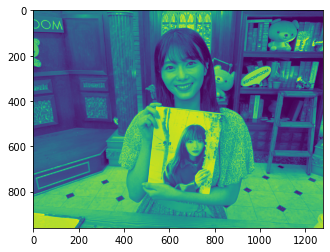

In [18]:
detect(base_dir)

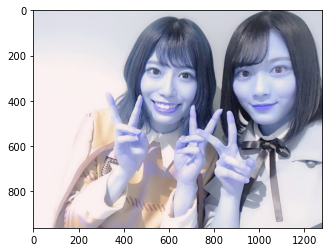

In [155]:
plt.imshow(input_img)

In [40]:
for image_file in os.listdir(base_dir):
    image_file

In [43]:
base_dir + '/' + image_file

'./predict/EzvJZVpUcAIlUE0.jpg'

In [9]:
def crop_color_face_test(item, img, predicted_dir):
    height, width, colors = img.shape
    hypot = int(math.hypot(height, width))
    frame = np.zeros((hypot, hypot, 3), np.uint8)
    frame[int((hypot - height) * 0.5):int((hypot + height) * 0.5), int((hypot - width) * 0.5):int((hypot + width) * 0.5)] = img

    deg = item['deg']
    M = cv2.getRotationMatrix2D((hypot * 0.5, hypot * 0.5), -deg, 1.0)
    rotated = cv2.warpAffine(frame, M, (hypot, hypot))

    x,y,w,h = item['frame']
    face = rotated[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))

    out_path = predicted_dir + '/' + 'predicted_' + item['img_path'] + '.jpg'
    print('out_path', out_path)
    cv2.imwrite(out_path, face)

    return out_path

In [122]:
base_dir2 = './result'

KeyError: 'img_pass'